## OptiWindNet + TopFarm Integration Example (Heuristic routers)

This notebook demonstrates how to use **OptiWindNet** in combination with **[TopFarm](https://gitlab.windenergy.dtu.dk/TOPFARM)**, a Python-based framework for wind farm layout optimization.

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [2]:
import importlib
if not importlib.util.find_spec("optiwindnet"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/OptiWindNet.git

### Import

In [3]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site

from optiwindnet.api import WindFarmNetwork, Heuristic

In [4]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Site

In [5]:
n_wt = 30
initial = np.asarray([np.random.random(30)*6000, np.random.random(30)*-10000]).T
x_init = initial[:,0]
y_init = initial[:,1]
boundary = np.array([(0, 0), (6000, 0), (6000, -10000), (0, -10000)])  # turbine boundaries
drivers = [EasyScipyOptimizeDriver(maxiter=1000)]
windTurbines = IEA37_WindTurbines()
site = Hornsrev1Site()
wfm = BastankhahGaussian(site, windTurbines)

c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\py_wake\deficit_models\gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


### Bathymetry

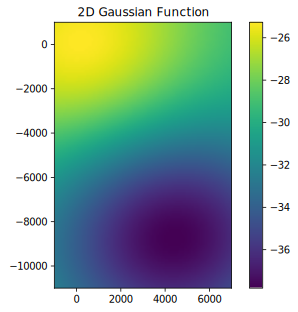

In [6]:
sigma = 3000.0
mu = 0.0

x_peak_1 = 1000
y_peak_1 = -1000
x_peak_2 = 4000
y_peak_2 = -8000
x1, y1 = np.meshgrid(np.linspace(0 - x_peak_1, 6000- x_peak_1, 100), np.linspace(-10000 - y_peak_1, 0 - y_peak_1, 100))
d1 = np.sqrt(x1*x1 + y1*y1)
g1 = np.exp(-((d1 - mu)**2 / (2.0 * sigma**2)))
x2, y2 = np.meshgrid(np.linspace(0 - x_peak_2, 6000- x_peak_2, 100), np.linspace(-10000 - y_peak_2, 0 - y_peak_2, 100))
d2 = np.sqrt(x2*x2 + y2*y2)
g2 = np.exp(-((d2 - mu)**2 / (2.0 * sigma**2)))
g = 5 * g1 - 8 * g2 - 30

plt.imshow(g, extent=(-1000, 7000, -11000, 1000), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Function')
plt.show()

x = np.linspace(-1000, 7000, 100)
y = np.linspace(-11000, 1000, 100)

f = RegularGridInterpolator((x, y), g)

### Cables

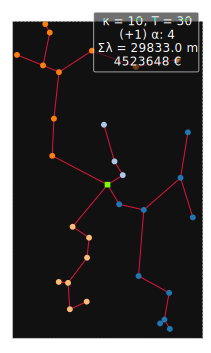

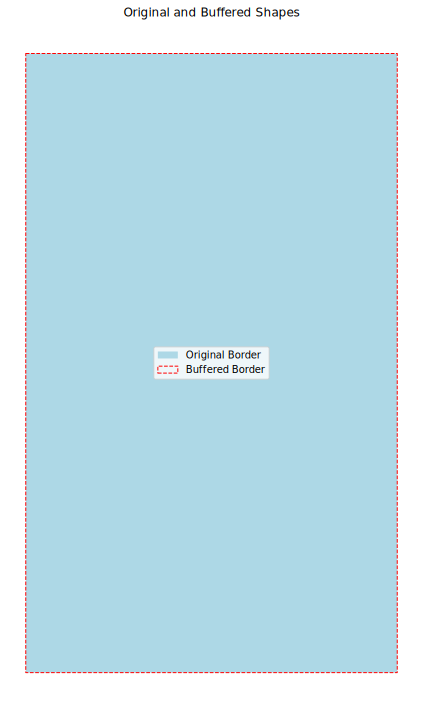

In [7]:
x_ss_init = x_init.mean()
y_ss_init = y_init.mean()
turbines_pos=  np.column_stack((x_init, y_init))
substations_pos =  np.column_stack((x_ss_init, y_ss_init))

cables = np.array([(3, 100),(5, 150), (10, 250)])  # Here you set up cables [<cable cross section>, <number of turbines can be connected>, <price in € per meter>]


# 'obstacles' is an optional location attribute
obstacles = []

border = boundary
wfn = WindFarmNetwork(turbinesC=turbines_pos, substationsC=substations_pos, borderC=border, cables=cables, buffer_dist=0.1)
router = Heuristic(solver='Esau_Williams')
res= wfn.optimize(router=router)
#G = wfn.optimize(turbines_pos)
cable_cost_ref = wfn.cost() # euro
cable_length_ref = wfn.length()  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

wfn.plot()
wfn.plot_original_vs_buffered()

### Economy

In [8]:
Drotor_vector = [windTurbines.diameter()] * n_wt
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt
hub_height_vector = [windTurbines.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 25            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
simres = wfm(x_init, y_init)
aep = simres.aep().values.sum()
CF = aep / (windTurbines.power(20)*1e-9 * 24*365*n_wt)

eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)
npv_ref = eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, 30, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)

### Python Functions

In [9]:
# Water Depth
def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(f(points).reshape(n_wt, n_wt).T)

# Cables
def cable_func(x, y, x_substation, y_substation, **kwargs):
    wfn.optimize(turbinesC= np.column_stack((x, y)), substationsC= np.column_stack((float(x_substation[0]), float(y_substation[0]))))
    print(wfn.cost())
    return wfn.cost(), {'cabling_length': wfn.length(), 'terse_links': wfn.terse_links()}

# Economy
def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return eco_eval.NPV, {'irr': eco_eval.IRR,
                          'OPEX': OPEX,
                          'CAPEX': CAPEX,}


### Components

In [10]:
# Water Depth
water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=water_depth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

# Cables
cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 0)],
                                     additional_output = [
                                                ('cabling_length', 0.0),
                                                ('terse_links', np.zeros((30,), dtype=int))
                                                ])

# Economy
npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 100000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)],
                              additional_output=[('irr', 0),
                                                 ('CAPEX', 0),
                                                 ('OPEX', 0)])

# AEP
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False)

### Problem Assembly

In [11]:
cost_comp = TopFarmGroup([PyWakeAEPCostModelComponent(wfm, n_wt, objective=False), water_depth_component, cable_component, npv_comp])


tf = TopFarmProblem(
    design_vars=dict(zip('xy', initial.T), x_substation=x_ss_init, y_substation=y_ss_init),
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary),
                 SpacingConstraint(500)
                 ],
    driver=drivers[0],
    plot_comp=XYPlotComp()
)


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000524 sec).
INFO: checking system...
INFO:     system check complete (0.000033 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000174 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000046 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000193 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000077 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000004 sec).


### Optimize

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000239 sec).
INFO: checking system...
INFO:     system check complete (0.000038 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000255 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000045 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000007 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000273 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000082 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


4523647.8682484375


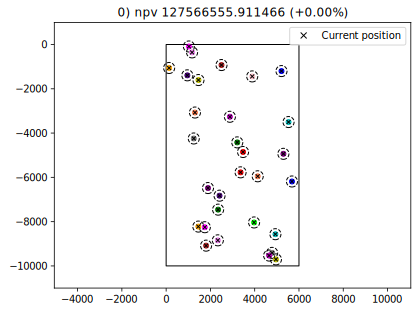

4587121.556396854
4587121.55649523
4587121.556281663
4587121.556369184
4587121.556412841
4587121.556456137
4587121.556501994
4587121.556346724
4587121.556297338
4587121.556620369
4587121.556397263
4587121.556426569
4587121.556476872
4587121.556305691
4587121.556381205
4587121.556392249
4587121.55625373
4587121.556426431
4587121.556533118
4587121.5562972175
4587121.556522328
4587121.556372928
4587121.556478157
4587121.556360533
4587121.556304125
4587121.556321544
4587121.556164035
4587121.556028783
4587121.556549393
4587121.556386872
4587121.556576952
4587121.556414805
4587121.556238399
4587121.556492949
4587121.556495568
4587121.556377837
4587121.556288481
4587121.556483381
4587121.556406676
4587121.556407897
4587121.556396877
4587121.556459491
4587121.556405756
4587121.556355752
4587121.556398055
4587121.556344161
4587121.556319683
4587121.556301328
4587121.556364404
4587121.556405378
4587121.5564243095
4587121.55638642
4587121.556532379
4587121.556335768
4587121.55643429
4587121.5563

In [ ]:
cost, _, recorder = tf.optimize()


### Plot

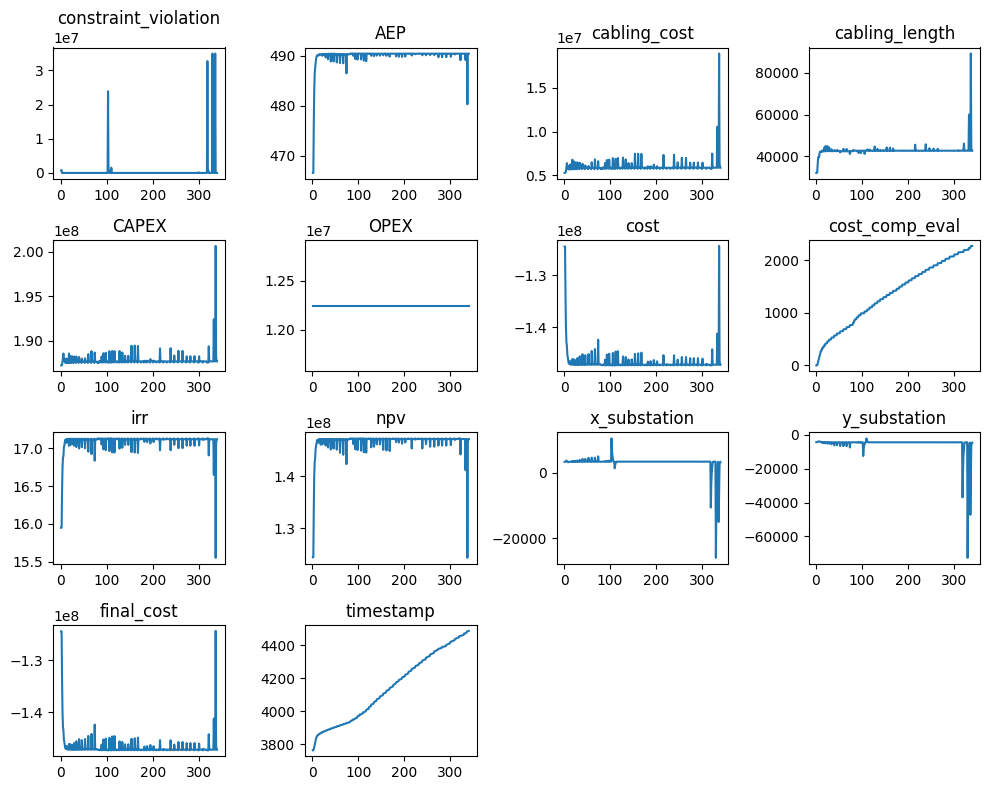

In [ ]:
plot_list_recorder(recorder)

### 🔄 Sync Final Network Layout from TopFarm to OptiWindNet

After TopFarm completes the optimization, the latest cable routing results are stored in the `terse_links` attribute of the TopFarm model output.

To apply the final cable layout back to the `wfn` (OptiWindNet) instance for further analysis or visualization, use:

```python
wfn.update_from_terse_links()


<Axes: >

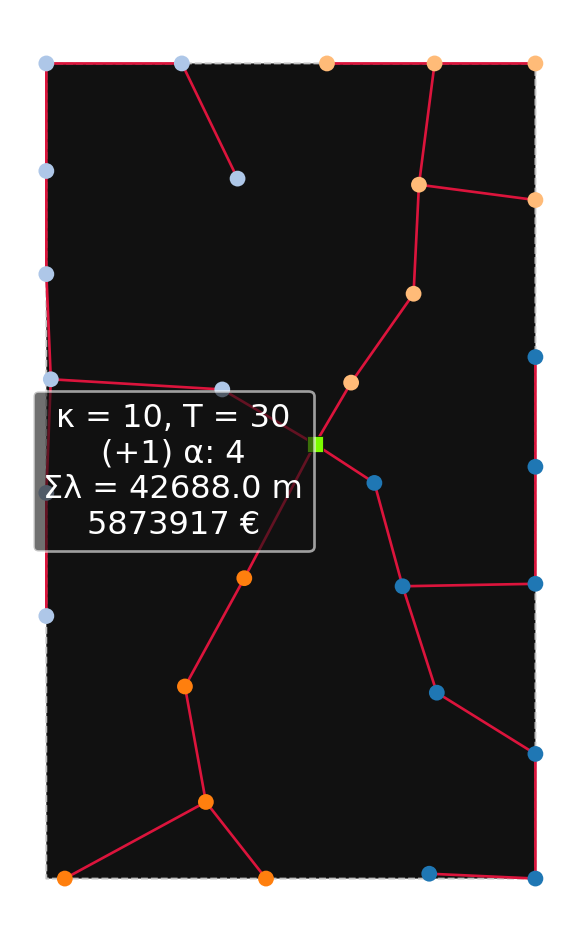

In [ ]:
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
x_sub_opt = recorder['x_substation'][-1]
y_sub_opt = recorder['y_substation'][-1]
terse_links = recorder['terse_links'][-1]


wfn.update_from_terse_links(terse_links=terse_links, turbinesC=np.column_stack((x_opt, y_opt)), substationsC= np.column_stack((float(x_sub_opt), float(y_sub_opt))))

wfn.plot()

Compare the result with optimization

<Axes: >

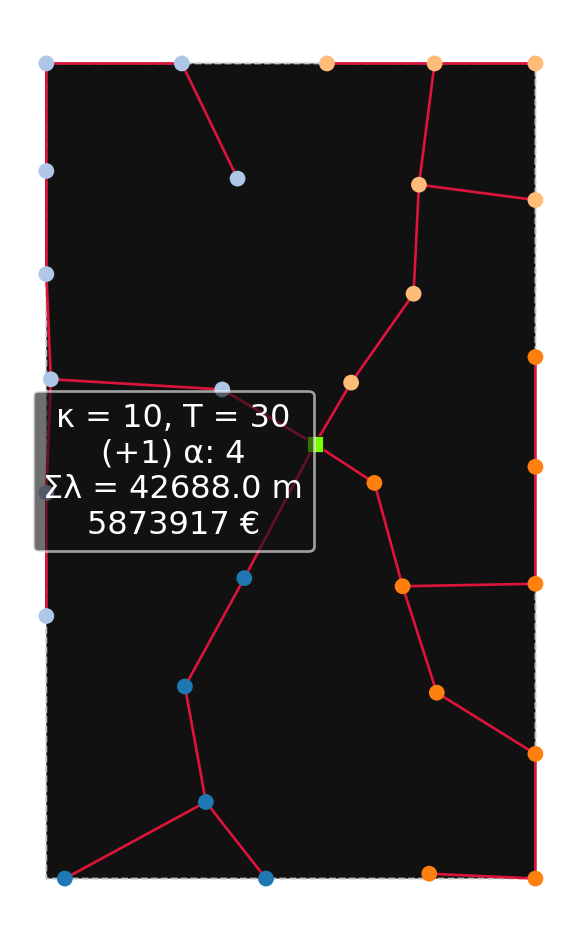

In [ ]:
wfn.optimize(turbinesC=np.column_stack((x_opt, y_opt)), substationsC= np.column_stack((float(x_sub_opt), float(y_sub_opt))))

wfn.plot()